In [49]:
using Revise
using FUSE
using IMAS
using Plots;
FUSE.logging(Logging.Info; actors=Logging.Debug);

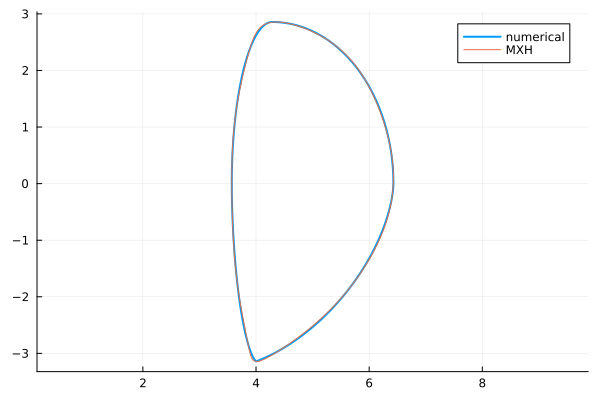

R0: 5.000054394587002
Z0: -0.1428571428571428
ϵ: 0.28570029868693436
κ: 2.100079963087586
c0: 0.10911297739268816
c: [0.10961035705787565, -0.04980113503653491, -0.03703494228375263, -0.01101131177637554, 0.011634358748907076]
s: [0.5313034050230345, 0.0585175391641101, -0.054898859966834926, -0.0026768726881637637, 0.029356585971247292]


:princeton_D_scaled

In [50]:
dd = IMAS.dd()
ini, act = FUSE.case_parameters(:FPP, version=:v2);

shape = :MXH

if shape == :miller
    ini.equilibrium.κ = 2.15
    ini.equilibrium.δ = 0.7
    ini.equilibrium.ζ = 0.05
    ini.equilibrium.𝚶 = 0.0

    ini.equilibrium.boundary_from = :scalars

else
    mhx_order = 5
    R0 = 5.0
    eps = 1/3.5
    a = R0*eps
    kapu = 2.0
    kapl = 2.2
    delu = 0.5
    dell = 0.7
    zetaou = -0.0
    zetaol = -0.4
    zetaiu = -0.0
    zetail = -0.2
    upnull = false
    lonull = true

    r, z, zref = try
        IMAS.boundary_shape(; a, eps, kapu, kapl, delu, dell, zetaou, zetaiu, zetaol, zetail, zoffset=0.0, upnull, lonull)
    catch e
        [NaN], [NaN], [NaN]
    end

    mxh = IMAS.MXH(r, z, mhx_order)
    mxh_vect = IMAS.flat_coeffs(mxh)

    ini.equilibrium.boundary_from = :MXH_params
    ini.equilibrium.MXH_params = mxh_vect

    plot(r, z; aspect_ratio=:equal, lw=2, label="numerical")
    display(plot!(mxh,label="MXH"))
    display(mxh)

end

ini.equilibrium.field_null_surface = 0.8
ini.equilibrium.xpoints = :lower

ini.build.plasma_gap = 0.125
ini.build.divertors = :lower
ini.build.symmetric = false

ini.equilibrium.ip = 8.0e6
ini.equilibrium.B0 = 6.0
ini.equilibrium.R0 = 5.0

ini.pf_active.n_coils_outside = 7
ini.pf_active.technology = :HTS

ini.tf.shape = :princeton_D_scaled

In [51]:
act.ActorHFSsizing.error_on_technology = false
act.ActorHFSsizing.stress_tolerance = 0.0
act.ActorHFSsizing.j_tolerance = 0.5

act.ActorPFactive.update_equilibrium = true
act.ActorPFactive.do_plot = true

act.ActorPFdesign.do_plot = true
act.ActorPFdesign.symmetric = false
act.ActorPFdesign.verbose = true

act.ActorCoreTransport.model = :FixedProfiles #:FluxMatcher

act.ActorFixedProfiles.T_shaping = ini.core_profiles.T_shaping
act.ActorFixedProfiles.n_shaping = ini.core_profiles.n_shaping
act.ActorFixedProfiles.T_ratio_core = ini.core_profiles.T_ratio

act.ActorStationaryPlasma.convergence_error = 5e-3

act.ActorThermalCycle.power_cycle_type = :fixed_cycle_efficiency
act.ActorThermalCycle.fixed_cycle_efficiency = 0.4

act.ActorCosting.model = :GASC

:GASC

In [52]:
# run INIT and copy dd

FUSE.init(dd, ini, act);
ddi = deepcopy(dd)

# modify secondary X-point

XP2_R = 4.1
XP2_Z = 4.0

dd.pulse_schedule.position_control.x_point[1].r.reference.data .= XP2_R
dd.pulse_schedule.position_control.x_point[1].z.reference.data .= XP2_Z

display(dd.pulse_schedule.position_control.x_point)

# add outer strike point to boundary

if false

    OSP_R = 4.0
    OSP_Z = -4.0

    using IMAS

    pc = dd.pulse_schedule.position_control
    time0 = 100.0

    resize!(pc.strike_point, 1; wipe=false)

    IMAS.set_time_array(pc.strike_point[1].r.reference, :data, time0, OSP_R)
    IMAS.set_time_array(pc.strike_point[1].z.reference, :data, time0, OSP_Z)

    display(dd.pulse_schedule.position_control.strike_point)

end

# run Whole Facility actor

empty!(dd.pf_active)
actor=FUSE.ActorWholeFacility(dd,act;update_plasma=true,update_build=false);


[ Info: Equilibrium
[ Info:  TEQUILA


[ Info: HCD
[ Info:  ECsimple
[ Info:  ICsimple
[ Info:  LHsimple
[ Info:  NBsimple
[ Info: SteadyStateCurrent
[ Info: CXbuild


x_point
├─ 1
│  ├─ r
│  │  └─ reference
│  │     ├─ data ➡ [4.1,4.1,4.1] [mixed]
│  │     └─ time ➡ [-Inf,100,Inf] [s]
│  └─ z
│     └─ reference
│        ├─ data ➡ [4,4,4] [mixed]
│        └─ time ➡ [-Inf,100,Inf] [s]
└─ 2
   ├─ r
   │  └─ reference
   │     ├─ data ➡ [3.98931,3.98931,3.98931] [mixed]
   │     └─ time ➡ [-Inf,100,Inf] [s]
   └─ z
      └─ reference
         ├─ data ➡ [-3.14225,-3.14225,-3.14225] [mixed]
         └─ time ➡ [-Inf,100,Inf] [s]


[ Info: WholeFacility
[ Info:  StationaryPlasma
[ Info:   HCD
[ Info:    ECsimple
[ Info:    ICsimple
[ Info:    LHsimple
[ Info:    NBsimple
[ Info:   Current
[ Info:    SteadyStateCurrent


[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal
[ Info:   HCD
[ Info:    ECsimple
[ Info:    ICsimple
[ Info:    LHsimple
[ Info:    NBsimple


[ Info:   Current
[ Info:    SteadyStateCurrent
[ Info:   Equilibrium
[ Info:    TEQUILA


[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal
[ Info:   HCD
[ Info:    ECsimple
[ Info:    ICsimple
[ Info:    LHsimple
[ Info:    NBsimple
[ Info:   Current
[ Info:    SteadyStateCurrent


[ Info:   Equilibrium
[ Info:    TEQUILA


[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal
[ Info:   HCD
[ Info:    ECsimple
[ Info:    ICsimple
[ Info:    LHsimple
[ Info:    NBsimple
[ Info:   Current


[ Info:    SteadyStateCurrent
[ Info:   Equilibrium
[ Info:    TEQUILA


[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal
[ Info:   HCD
[ Info:    ECsimple
[ Info:    ICsimple
[ Info:    LHsimple
[ Info:    NBsimple


[ Info:   Current
[ Info:    SteadyStateCurrent
[ Info:   Equilibrium
[ Info:    TEQUILA


[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal
[ Info:   HCD
[ Info:    ECsimple
[ Info:    ICsimple
[ Info:    LHsimple
[ Info:    NBsimple


[ Info:   Current
[ Info:    SteadyStateCurrent
[ Info:   Equilibrium
[ Info:    TEQUILA


[ Info:  StabilityLimits
[ Info:  FluxSwing
[ Info:  Stresses
[ Info:  Neutronics


[ Info:  Blanket


[ Info:   CXbuild


[ Info:  Divertors


[ Info:  BalanceOfPlant
[ Info:   HeatTransfer
[ Info:   ThermalCycle
[ Info:   PowerNeeds
[ Info:  Costing
[ Info:   GASCCosting
[ Info:    SheffieldCosting
┌ Warning: Inflation data not available for 2010
└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing/costing_utils.jl:122


┌ Warning: Inflation data not available for 1983
└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing/costing_utils.jl:122
┌ Warning: Inflation data not available for 1983
└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing/costing_utils.jl:122
┌ Warning: Inflation data not available for 1983
└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing/costing_utils.jl:122


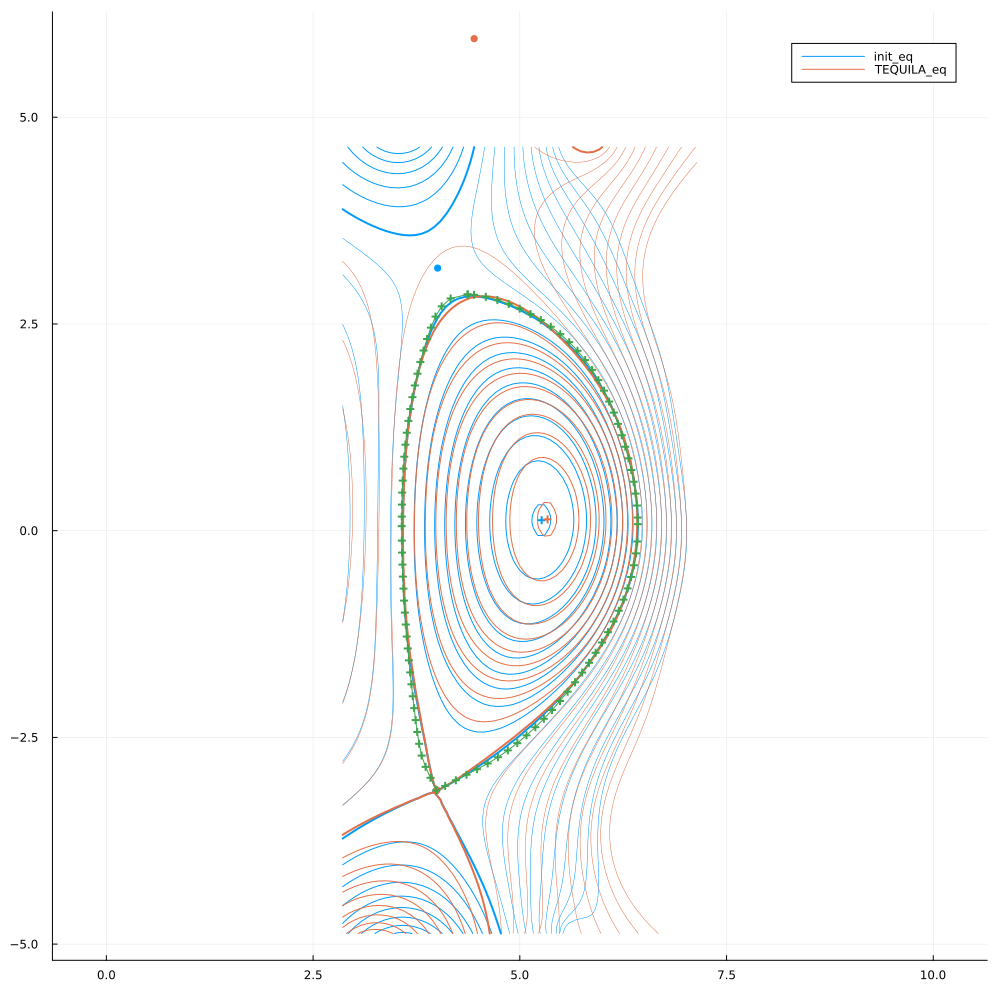

x_point
├─ 1
│  ├─ r
│  │  └─ reference
│  │     ├─ data ➡ [NaN,NaN,NaN] [mixed]
│  │     └─ time ➡ [-Inf,100,Inf] [s]
│  └─ z
│     └─ reference
│        ├─ data ➡ [NaN,NaN,NaN] [mixed]
│        └─ time ➡ [-Inf,100,Inf] [s]
└─ 2
   ├─ r
   │  └─ reference
   │     ├─ data ➡ [3.98931,3.98931,3.98931] [mixed]
   │     └─ time ➡ [-Inf,100,Inf] [s]
   └─ z
      └─ reference
         ├─ data ➡ [-3.14225,-3.14225,-3.14225] [mixed]
         └─ time ➡ [-Inf,100,Inf] [s]


x_point
├─ x_point
│  ├─ r ➡ 3.98878 [m]
│  └─ z ➡ -3.14432 [m]
└─ x_point
   ├─ r ➡ 4.00637 [m]
   └─ z ➡ 3.17556 [m]


x_point
├─ 1
│  ├─ r
│  │  └─ reference
│  │     ├─ data ➡ [4.1,4.1,4.1] [mixed]
│  │     └─ time ➡ [-Inf,100,Inf] [s]
│  └─ z
│     └─ reference
│        ├─ data ➡ [4,4,4] [mixed]
│        └─ time ➡ [-Inf,100,Inf] [s]
└─ 2
   ├─ r
   │  └─ reference
   │     ├─ data ➡ [3.98931,3.98931,3.98931] [mixed]
   │     └─ time ➡ [-Inf,100,Inf] [s]
   └─ z
      └─ reference
         ├─ data ➡ [-3.14225,-3.14225,-3.14225] [mixed]
         └─ time ➡ [-Inf,100,Inf] [s]


boundary
├─ elongation ➡ 2.09991
├─ elongation_lower ➡ Function
├─ elongation_upper ➡ Function
├─ geometric_axis
│  ├─ r ➡ 4.99997 [m]
│  └─ z ➡ -0.116081 [m]
├─ minor_radius ➡ 1.42845 [m]
├─ outline
│  ├─ r ➡ 239-element Vector{Float64} [m]
│  └─ z ➡ 239-element Vector{Float64} [m]
├─ squareness ➡ -0.0604521
├─ squareness_lower_inner ➡ Function
├─ squareness_lower_outer ➡ Function
├─ squareness_upper_inner ➡ Function
├─ squareness_upper_outer ➡ Function
├─ triangularity ➡ 0.506185
├─ triangularity_lower ➡ Function
├─ triangularity_upper ➡ Function
└─ x_point
   ├─ x_point
   │  ├─ r ➡ 3.98869 [m]
   │  └─ z ➡ -3.14527 [m]
   └─ x_point
      ├─ r ➡ 4.44794 [m]
      └─ z ➡ 5.95058 [m]


┌ Warning: Skipped marker arg circle.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149


In [53]:
p = plot(size=(1000,1000))
plot!(p, ddi.equilibrium; cx=true ,show_x_points=true, label="init_eq")
plot!(p, dd.equilibrium; cx=true, show_x_points=true, label="TEQUILA_eq")
plot!(p, dd.pulse_schedule.position_control, marker=:cross, label="TEQUILA_position_control")

display(p)

display(ddi.pulse_schedule.position_control.x_point)
display(ddi.equilibrium.time_slice[].boundary.x_point)
display(dd.pulse_schedule.position_control.x_point)
display(dd.equilibrium.time_slice[].boundary)

In [54]:
import MXHEquilibrium as MXH

boundary = MXH.Boundary(dd.equilibrium.time_slice[].boundary.outline.r, dd.equilibrium.time_slice[].boundary.outline.z)

MXH.boundary_extrema(boundary)

((6.420569044509209, 0.0904764905234434), (4.570718533942253, 2.8350671603691504), (3.5875824725676826, -0.039274236130619825), (4.039802670159182, -3.12840716377475))

In [55]:
dd.pulse_schedule.position_control.boundary_outline

boundary_outline
├─ 1
│  ├─ r
│  │  └─ reference
│  │     ├─ data ➡ [6.14303,4.36896,4.36896] [mixed]
│  │     └─ time ➡ [-Inf,100,Inf] [s]
│  └─ z
│     └─ reference
│        ├─ data ➡ [-0.143614,2.85696,2.85696] [mixed]
│        └─ time ➡ [-Inf,100,Inf] [s]
├─ 2
│  ├─ r
│  │  └─ reference
│  │     ├─ data ➡ [6.14074,4.44547,4.44547] [mixed]
│  │     └─ time ➡ [-Inf,100,Inf] [s]
│  └─ z
│     └─ reference
│        ├─ data ➡ [-0.215763,2.85291,2.85291] [mixed]
│        └─ time ➡ [-Inf,100,Inf] [s]
├─ 3
│  ├─ r
│  │  └─ reference
│  │     ├─ data ➡ [6.13388,4.58853,4.58853] [mixed]
│  │     └─ time ➡ [-Inf,100,Inf] [s]
│  └─ z
│     └─ reference
│        ├─ data ➡ [-0.287621,2.82869,2.82869] [mixed]
│        └─ time ➡ [-Inf,100,Inf] [s]
├─ 4
│  ├─ r
│  │  └─ reference
│  │     ├─ data ➡ [6.12247,4.72856,4.72856] [mixed]
│  │     └─ time ➡ [-Inf,100,Inf] [s]
│  └─ z
│     └─ reference
│        ├─ data ➡ [-0.358899,2.79052,2.79052] [mixed]
│        └─ time ➡ [-Inf,100,Inf] [s]
├─ 5
│  ├─ 